<div class="alert alert-block alert-success">
    <h1 align="center"></h1>
    <h1 align="left">Mac De_Randomization</h3>
    <h4 align="left"><a href="https://github.com/Mohammad-Amirifard">Mohammad Amirifard</a></h5>

</div>

<div style="display: flex; justify-content: center;">
    <img src="https://www.dfrc-group.com/wp-content/uploads/2019/06/randomised-MAC-address-1024x703-1.png" width="50%">
</div>


# Problem Statement
Implement **online clustering** for probe requests using the lecture dataset. Upon receiving a probe request, choose between creating a new cluster or assigning it to an existing one. Decision depends on **feature similarity**, with a probe joining a cluster if at least N features match. Resolve ties as preferred. Test various N values to optimize cluster performance (**v-measure and error**).

Validate the approach on a new dataset in the challenge-dataset folder, with **6 labeled devices**. Perform validation at different test-set sizes (K), creating and testing on multiple test sets. Plot average performance measures vs K and analyze results.


# Goal
Run the best technique on the new unlabeled dataset (unlabelled-challenge.csv) **to estimate the number of devices**.

# 1)Upload datasets


In [1]:
!gdown 1ITHMMBXnPR4hS4jfW07xBSSgSTNU1zrU # Download MAC_derand_lecture-dataset.zip dataset form goole drive
!gdown 18HlDcQVtwzDGfHz0aKUGwZsiwd61SC8A # Download MAC_derand_challenge-dataset.zip dataset form goole drive
!gdown 1o_azEvBfWJJG3bFyJ1dWiAU6ayuf64tN # Download MAC_derand_unlabelled_challenge.csv

# Unzip them
! unzip -qq '/content/MAC_derand_lecture-dataset.zip'
! unzip -qq '/content/MAC_derand_challenge-dataset.zip'

# If you cannot download datasets, please refer to this link:
# https://drive.google.com/drive/folders/1JXAIdCKvFNpfFWCwP2BCrHMdmgJLGc1o?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1ITHMMBXnPR4hS4jfW07xBSSgSTNU1zrU
To: /content/MAC_derand_lecture-dataset.zip
100% 53.1k/53.1k [00:00<00:00, 62.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=18HlDcQVtwzDGfHz0aKUGwZsiwd61SC8A
To: /content/MAC_derand_challenge-dataset.zip
100% 82.6k/82.6k [00:00<00:00, 60.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o_azEvBfWJJG3bFyJ1dWiAU6ayuf64tN
To: /content/MAC_derand_unlabelled-challenge.csv
100% 3.55M/3.55M [00:00<00:00, 58.8MB/s]


# 2)Import libraries

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
import itertools
from sklearn.metrics import homogeneity_completeness_v_measure
import random
from sklearn.preprocessing import LabelEncoder
import math
import warnings
warnings.filterwarnings('ignore')

# 3)Load train dataset

In [3]:
base_dir = '/content/lecture-dataset/' # This the directory of avaialable datasets

# We do the following code to read all and combine them to one csv file

df_list = list()

for root, dirs, files in os.walk(base_dir):
  for file in files:
    if file.endswith(".csv"):
      file_path = os.path.join(root,file)

      df = pd.read_csv(file_path) # read csv file and
      df_list.append(df) # add it to df_list
original_dataset = pd.concat(df_list, ignore_index=True) # combine all csv files together

original_dataset['Timestamp']=pd.to_datetime(original_dataset['Timestamp'], unit='s') # turn timestamp to a readable one

display(original_dataset)



,Timestamp,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Label
0,2021-07-08 08:07:27.307995136,7a:e3:17:f9:50:df,1,1.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,NaN,02040b16,0c1218243048606c,NaN,NaN,121,SamsungJ6_K
1,2021-07-08 08:07:27.308015104,7a:e3:17:f9:50:df,11,1.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,NaN,02040b16,0c1218243048606c,NaN,NaN,121,SamsungJ6_K
2,2021-07-08 08:07:27.318708992,7a:e3:17:f9:50:df,11,1.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,NaN,02040b16,0c1218243048606c,NaN,NaN,121,SamsungJ6_K
3,2021-07-08 08:07:27.318726144,7a:e3:17:f9:50:df,1,1.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,NaN,02040b16,0c1218243048606c,NaN,NaN,121,SamsungJ6_K
4,2021-07-08 08:07:27.397764864,7a:e3:17:f9:50:df,11,2.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,NaN,02040b16,0c1218243048606c,NaN,NaN,121,SamsungJ6_K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4983,2023-05-20 13:48:50.284313088,c2:36:7b:35:f4:a5,6,6.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,NaN,82848b96,0c1218243048606c,NaN,020014,193,S21Ultra-M_a
4984,2023-05-20 13:48:50.494008064,c2:36:7b:35:f4:a5,11,11.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,NaN,82848b96,0c1218243048606c,NaN,020014,193,S21Ultra-M_a
4985,2023-05-20 13:48:50.514439936,c2:36:7b:35:f4:a5,11,11.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,NaN,82848b96,0c1218243048606c,NaN,020014,193,S21Ultra-M_a
4986,2023-05-20 13:49:40.855052032,f6:e8:46:ec:d1:90,6,6.0,2d001bffff000000000000000000000000000000000000...,8.000000e+10,NaN,NaN,82848b96,0c1218243048606c,NaN,23010808180080203002000d009f08000000f5fff5ff39...,132,S21Ultra-M_a


# 4)EDA part

## 4_1)dataset info

In [4]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Timestamp                 4988 non-null   datetime64[ns]
 1   MAC Address               4988 non-null   object        
 2   Channel                   4988 non-null   int64         
 3   DS Channel                4959 non-null   float64       
 4   HT Capabilities           4987 non-null   object        
 5   Extended Capabilities     4987 non-null   float64       
 6   Vendor Specific Tags      4045 non-null   object        
 7   SSID                      427 non-null    object        
 8   Supported Rates           4988 non-null   object        
 9   Extended Supported Rates  4987 non-null   object        
 10  VHT Capabilities          0 non-null      float64       
 11  HE Capabilities           933 non-null    object        
 12  Length              

## 4_2)Remove columns with nan values more than 60 % of total

In [5]:
nan_sum = original_dataset.isna().sum()
print('The following part dentoes the number of nan values in each column')
print('='*80)
print(nan_sum)

The following part dentoes the number of nan values in each column
Timestamp                      0
MAC Address                    0
Channel                        0
DS Channel                    29
HT Capabilities                1
Extended Capabilities          1
Vendor Specific Tags         943
SSID                        4561
Supported Rates                0
Extended Supported Rates       1
VHT Capabilities            4988
HE Capabilities             4055
Length                         0
Label                          0
dtype: int64


In [6]:
# Calculate how much percent for  ecach
nan_percentage = (nan_sum/len(original_dataset))*100
print('The following part is showing the percentage of nan values in each column')
print('='*80)
print(nan_percentage)

The following part is showing the percentage of nan values in each column
Timestamp                     0.000000
MAC Address                   0.000000
Channel                       0.000000
DS Channel                    0.581395
HT Capabilities               0.020048
Extended Capabilities         0.020048
Vendor Specific Tags         18.905373
SSID                         91.439455
Supported Rates               0.000000
Extended Supported Rates      0.020048
VHT Capabilities            100.000000
HE Capabilities              81.295108
Length                        0.000000
Label                         0.000000
dtype: float64


In [7]:
# remove them
col_drop = []

for i in range(0,len(nan_percentage)):
  if nan_percentage[i] > 60:
    col_drop.append(nan_percentage.index[i])
print('The following columns has been deleted from dataset since they had more than 60% nan values inside themselves')
print('='*110)
print('\t\t\t',col_drop)


clean_original_dataset = original_dataset.drop(col_drop, axis=1)


The following columns has been deleted from dataset since they had more than 60% nan values inside themselves
			 ['SSID', 'VHT Capabilities', 'HE Capabilities']


In [8]:
# Remove timestamp
clean_original_dataset.drop(['Timestamp'],axis=1,inplace=True)
print('\nNow dataset is like this:')
display(clean_original_dataset)


Now dataset is like this:


,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,7a:e3:17:f9:50:df,1,1.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,02040b16,0c1218243048606c,121,SamsungJ6_K
1,7a:e3:17:f9:50:df,11,1.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,02040b16,0c1218243048606c,121,SamsungJ6_K
2,7a:e3:17:f9:50:df,11,1.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,02040b16,0c1218243048606c,121,SamsungJ6_K
3,7a:e3:17:f9:50:df,1,1.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,02040b16,0c1218243048606c,121,SamsungJ6_K
4,7a:e3:17:f9:50:df,11,2.0,21001fff00000000000000000000000000000000000000...,8.001000e+03,001018020000000000,02040b16,0c1218243048606c,121,SamsungJ6_K
...,...,...,...,...,...,...,...,...,...,...
4983,c2:36:7b:35:f4:a5,6,6.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,82848b96,0c1218243048606c,193,S21Ultra-M_a
4984,c2:36:7b:35:f4:a5,11,11.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,82848b96,0c1218243048606c,193,S21Ultra-M_a
4985,c2:36:7b:35:f4:a5,11,11.0,2d001bffff000000000000000000000000000000000000...,4.004880e+18,00904c0408bf0c7678910ffaff0000faff0020,82848b96,0c1218243048606c,193,S21Ultra-M_a
4986,f6:e8:46:ec:d1:90,6,6.0,2d001bffff000000000000000000000000000000000000...,8.000000e+10,NaN,82848b96,0c1218243048606c,132,S21Ultra-M_a


## 4_3)Choose columns with maximum 20 unique values and call them features

In [9]:
unique_elem = clean_original_dataset.nunique()

print(unique_elem)

features = []

for i in range(0,len(unique_elem)-1):
  if unique_elem[i] < 20:
    features.append(unique_elem.index[i])
print('='*80)
print('We have selected the folliwing columns as our features:\n')
print('\t\t\t\t||')
print('\t\t\t\t||')
print('\t\t\t\t')
for feature in features:
  print(feature)


MAC Address                 718
Channel                       3
DS Channel                   13
HT Capabilities               8
Extended Capabilities         7
Vendor Specific Tags          5
Supported Rates               4
Extended Supported Rates      2
Length                       16
Label                         7
dtype: int64
We have selected the folliwing columns as our features:

				||
				||
				
Channel
DS Channel
HT Capabilities
Extended Capabilities
Vendor Specific Tags
Supported Rates
Extended Supported Rates
Length


## 4_4)Label Encoding

In [10]:

# label encoding on some columns except 'Length, Channel, DS Channel'
def encoder(df,features):
  df_tmp = df.copy()
  for elem in features:
    if elem != 'Lenght' and elem != 'Channel' and elem != 'DS Channel':
      label_encoder = LabelEncoder()
      df_tmp[elem] = label_encoder.fit_transform(df_tmp[elem].astype(str))

  # encode Label for correlation matrxi

  df_tmp[features]=df_tmp[features].astype(float)
  return df_tmp

encoded_dataset = encoder(clean_original_dataset,features)
display(encoded_dataset)

,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,7a:e3:17:f9:50:df,1.0,1.0,1.0,4.0,0.0,0.0,0.0,3.0,SamsungJ6_K
1,7a:e3:17:f9:50:df,11.0,1.0,1.0,4.0,0.0,0.0,0.0,3.0,SamsungJ6_K
2,7a:e3:17:f9:50:df,11.0,1.0,1.0,4.0,0.0,0.0,0.0,3.0,SamsungJ6_K
3,7a:e3:17:f9:50:df,1.0,1.0,1.0,4.0,0.0,0.0,0.0,3.0,SamsungJ6_K
4,7a:e3:17:f9:50:df,11.0,2.0,1.0,4.0,0.0,0.0,0.0,3.0,SamsungJ6_K
...,...,...,...,...,...,...,...,...,...,...
4983,c2:36:7b:35:f4:a5,6.0,6.0,4.0,1.0,4.0,1.0,0.0,12.0,S21Ultra-M_a
4984,c2:36:7b:35:f4:a5,11.0,11.0,4.0,1.0,4.0,1.0,0.0,12.0,S21Ultra-M_a
4985,c2:36:7b:35:f4:a5,11.0,11.0,4.0,1.0,4.0,1.0,0.0,12.0,S21Ultra-M_a
4986,f6:e8:46:ec:d1:90,6.0,6.0,4.0,3.0,5.0,1.0,0.0,5.0,S21Ultra-M_a


## 4_5)Groupby Mac Address

In [11]:
# see unique mac addresses
unique_mac_addresses = len(np.unique(encoded_dataset['MAC Address']))
print(f'We have: {unique_mac_addresses} unique Mac addresses')
print('='*80)
grouped_dataset = encoded_dataset.groupby(['MAC Address']) # Group by Mac Address
grouped_dataset = grouped_dataset.first().reset_index() # Show first row of groupd mac address
display(grouped_dataset)

We have: 718 unique Mac addresses


,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label
0,00:0f:00:6a:68:8b,1.0,NaN,8.0,7.0,5.0,3.0,2.0,15.0,SamsungJ6_K
1,00:78:b5:8a:40:84,11.0,10.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
2,00:c6:7e:33:8c:62,11.0,11.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
3,00:cb:d6:50:04:2c,11.0,10.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
4,01:31:03:f5:11:4b,11.0,11.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
...,...,...,...,...,...,...,...,...,...,...
713,fe:7b:b8:60:08:c7,11.0,13.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a
714,fe:9d:55:a5:9f:4a,1.0,1.0,6.0,5.0,5.0,1.0,0.0,6.0,iPhone12_W
715,fe:d8:06:8a:6a:09,1.0,1.0,3.0,3.0,5.0,0.0,0.0,2.0,iPhoneXR-U
716,fe:f9:fc:fb:83:9e,6.0,6.0,2.0,2.0,1.0,0.0,0.0,9.0,iPhone6_N


# 5)Feature Selection

## 5_1)Correlation matrix

In [12]:
# We need to fill nan values in features and then encode Label column to use correlation matrix
nan_sum = grouped_dataset.isna().sum()
print('The following part dentoes the number of nan values in each column')
print('='*80)
print(nan_sum)

The following part dentoes the number of nan values in each column
MAC Address                 0
Channel                     0
DS Channel                  1
HT Capabilities             0
Extended Capabilities       0
Vendor Specific Tags        0
Supported Rates             0
Extended Supported Rates    0
Length                      0
Label                       0
dtype: int64


In [13]:
# Just only one nan in the DS Channel must be filled
grouped_dataset['DS Channel'].fillna(value=1.0, inplace=True) # fill with value=1, since it is the most common DS Cahnnel found

In [14]:
correlation_dataset = grouped_dataset[features].copy()
correlation_dataset['Label'] = grouped_dataset['Label']
label_encoder = LabelEncoder() # Let's encode Mac and Label columns to see correlation matrix
correlation_dataset['Label'] = label_encoder.fit_transform(correlation_dataset['Label'].astype(str))


Channel                     0.242620
DS Channel                  0.278936
HT Capabilities             0.486363
Extended Capabilities      -0.363437
Vendor Specific Tags        0.176417
Supported Rates             0.148748
Extended Supported Rates   -0.025376
Length                     -0.433794
Label                       1.000000
Name: Label, dtype: float64


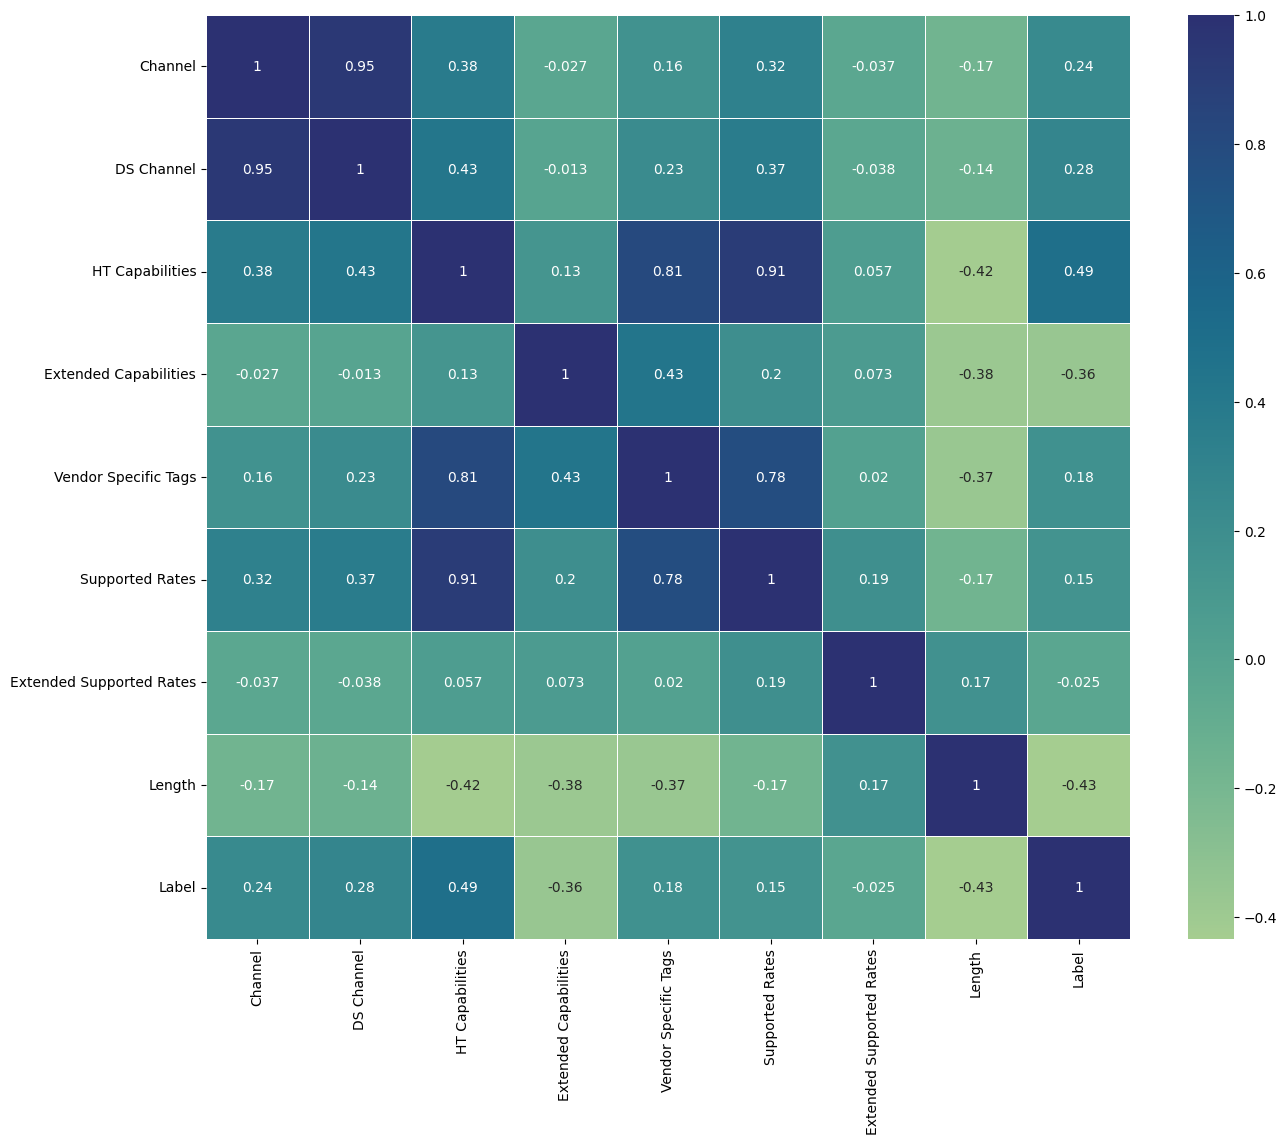

In [15]:
# We need to know the effect of fetures on each other and on traget
f, ax = plt.subplots(figsize=(15, 12))
corr = correlation_dataset.corr()
sns.heatmap((corr ),annot=True,linewidth=.5,
            cmap='crest',
            square=True, ax=ax)#, vmin=0, vmax=100)

print(corr['Label'])
print('='*80)


###5_1_1)Recommended features


In [16]:
all_recommended_features_dict = {}
print('Recommended features from Correlation matrix method to use is :')
all_recommended_features_dict['Correlation Matirx Method'] = ['HT Capabilities','Lenght','Extended Capabilities','DS Channel', 'Channel']
print("['HT Capabilities','Lenght','Extended Capabilities','DS Channel', 'Channel']")
print('='*80)

Recommended features from Correlation matrix method to use is :
['HT Capabilities','Lenght','Extended Capabilities','DS Channel', 'Channel']


## 5_2)Mutual Info/Gain Entropy

In [17]:
x_train =grouped_dataset[features].copy()
y_train =grouped_dataset['Label'].copy()
mutual_info = mutual_info_classif(x_train,y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train.columns
mutual_info.sort_values(ascending=False)
display(mutual_info)
print('='*80)

Channel                     0.214705
DS Channel                  0.443298
HT Capabilities             1.130189
Extended Capabilities       1.021078
Vendor Specific Tags        0.931968
Supported Rates             0.616476
Extended Supported Rates    0.000000
Length                      1.527830
dtype: float64

###5_2_1) Recommended features

In [18]:
print('Recommended features from Mutual Info method to use is :')
all_recommended_features_dict['Mutual Info Method'] = ['Lenght','HT Capabilities','Extended Capabilities','Vendor Specific Tags', 'Supported Rates']
print("['Lenght','HT Capabilities','Extended Capabilities','Vendor Specific Tags', 'Supported Rates']")
print('='*80)

Recommended features from Mutual Info method to use is :
['Lenght','HT Capabilities','Extended Capabilities','Vendor Specific Tags', 'Supported Rates']


## 5_3)Cross Tab/Heat Map

In [19]:
def plot_heatmap(df, features, colormap="Blues"):


  sns.set_theme(style="whitegrid",font_scale=1)
  titles = features
  fig, axs = plt.subplots(4, 2, figsize=(20, 32))

  #sns.heatmap(crosstab,annot=True, fmt="d", cmap=colormap)
  # Plot data and set titles using a loop
  for i, ax in enumerate(axs.flat):
    crosstab = pd.crosstab(df['Label'], df[features[i]])
    sns.heatmap(crosstab,annot=True, ax=ax,fmt="d", cmap=colormap)
    ax.set_title(titles[i])
    ax.set_xlabel(titles[i])
    ax.set_ylabel('Label')

  # Adjust layout
  plt.tight_layout()

  # Show the plots
  plt.show()





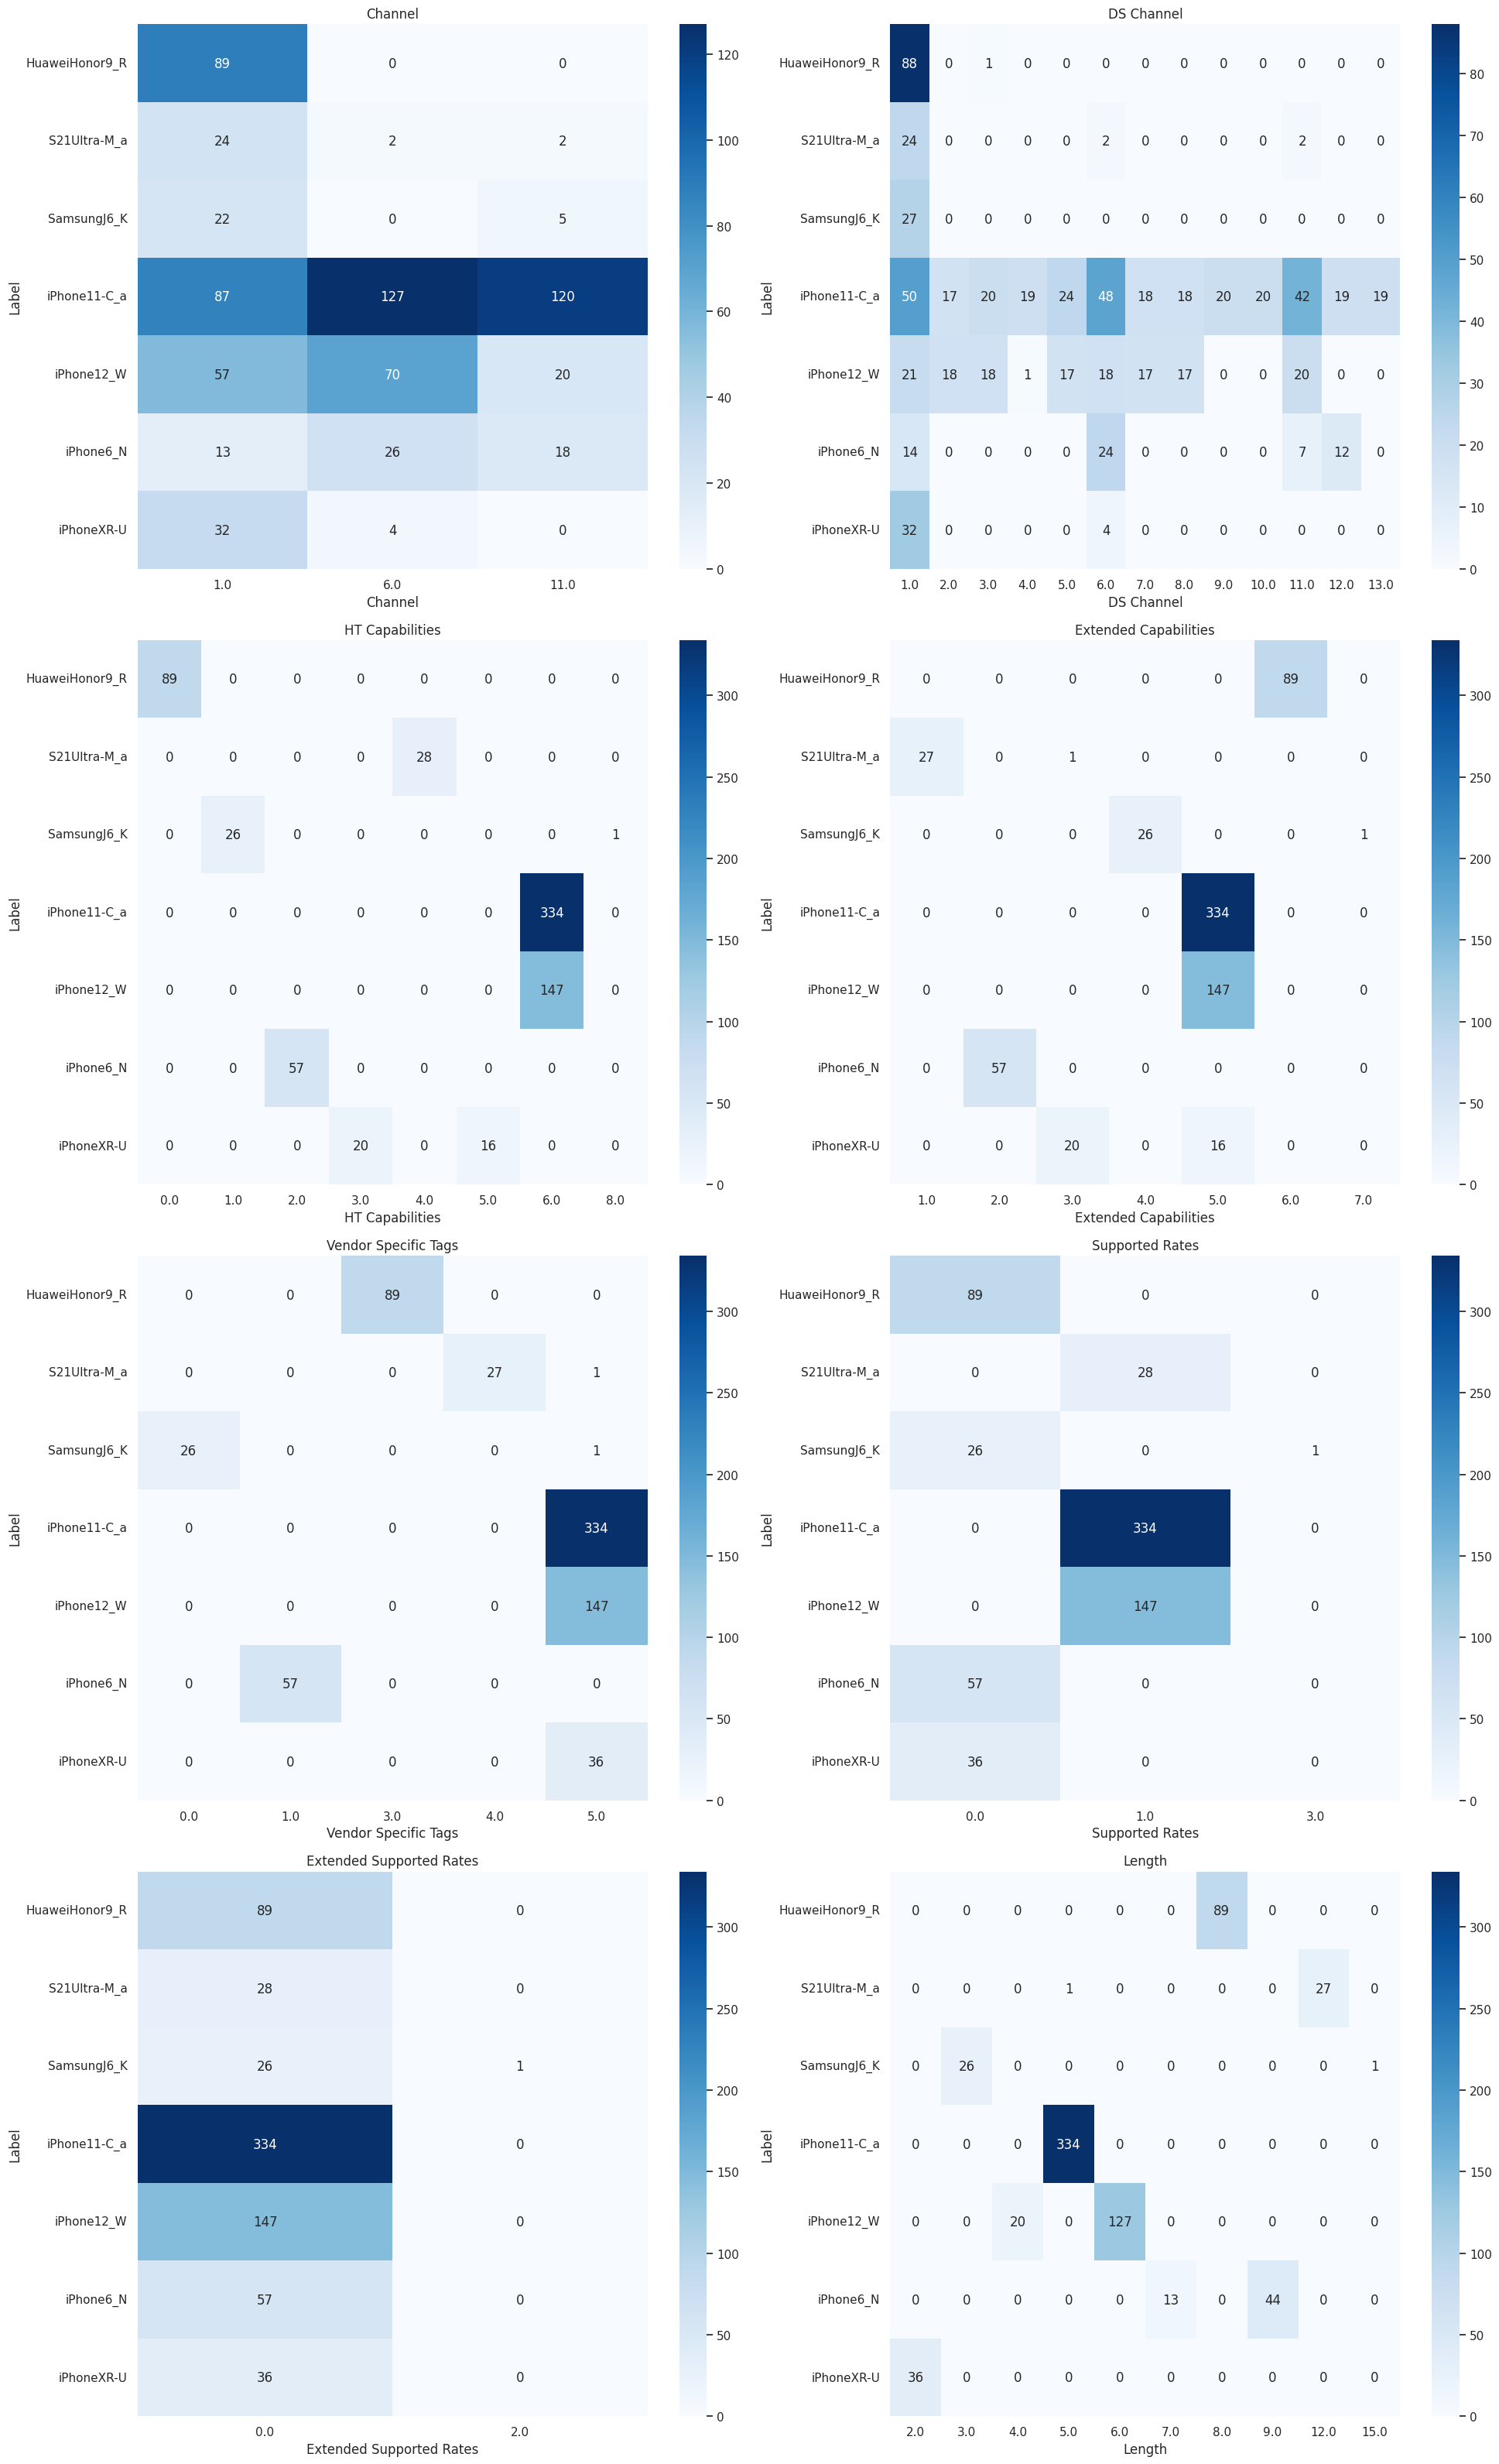

In [20]:
# In the following codes, you see the correlations of columns with each other
plot_heatmap(grouped_dataset,features)

### 5_3_1)Recommended features

In [21]:
print('Recommended features from Cross Tab method to use is :')
all_recommended_features_dict['Cross Tab Method'] = ['Lenght','HT Capabilities','Extended Capabilities']
print("['Lenght','HT Capabilities','Extended Capabilities']")
print('='*80)

Recommended features from Cross Tab method to use is :
['Lenght','HT Capabilities','Extended Capabilities']


## 5_4)Broute Force combinations

In [22]:
all_feature_combinations = []

for r in range(1, len(features)+1):
    all_feature_combinations.extend(itertools.combinations(features, r))


# Create a table to store all feature combinations performance on our datasets
first_performance_table = pd.DataFrame({},index=['Homogeneous','completeness','V_measure','No_of_Clusters','No_Labels','Error'])


# See and save performance of all feature combinations on first performance table
brute_force_df = grouped_dataset.copy()
for index,item in enumerate(all_feature_combinations):
  selected_features = list(item)
  brute_force_df[f"Cluster_{index}"]=brute_force_df.groupby(selected_features).ngroup() # Group by seleceted features and give them a number
  result = homogeneity_completeness_v_measure(brute_force_df["Label"],brute_force_df[f"Cluster_{index}"])
  No_of_Clusters = len(np.unique(brute_force_df[f"Cluster_{index}"]))
  No_Labels = len(np.unique(brute_force_df["Label"]))
  Error = No_of_Clusters-No_Labels
  result = list(result)
  result.append(No_of_Clusters)
  result.append(No_Labels)
  result.append(Error)


  result = np.reshape(result,(6,1))
  first_performance_table[f'Cluster_{index}'] = result



In [23]:
first_performance_table

,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,...,Cluster_245,Cluster_246,Cluster_247,Cluster_248,Cluster_249,Cluster_250,Cluster_251,Cluster_252,Cluster_253,Cluster_254
Homogeneous,0.138779,0.279538,0.732336,0.664772,0.601125,0.393349,0.002982,0.993841,0.294904,0.744822,...,1.000000,0.772558,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
completeness,0.201420,0.199372,0.965429,0.956649,0.987244,0.990266,0.435426,0.918410,0.205508,0.565175,...,0.900375,0.398899,0.462071,0.462071,0.462071,0.462071,0.462071,0.635206,0.465102,0.462071
V_measure,0.164332,0.232745,0.832881,0.784440,0.747253,0.563047,0.005924,0.954638,0.242221,0.642680,...,0.947576,0.526135,0.632078,0.632078,0.632078,0.632078,0.632078,0.776913,0.634907,0.632078
No_of_Clusters,3.000000,13.000000,8.000000,7.000000,5.000000,3.000000,2.000000,10.000000,16.000000,16.000000,...,12.000000,31.000000,40.000000,40.000000,40.000000,40.000000,40.000000,20.000000,38.000000,40.000000
No_Labels,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
Error,-4.000000,6.000000,1.000000,0.000000,-2.000000,-4.000000,-5.000000,3.000000,9.000000,9.000000,...,5.000000,24.000000,33.000000,33.000000,33.000000,33.000000,33.000000,13.000000,31.000000,33.000000


In [24]:
best_Errors = first_performance_table.columns[(first_performance_table.loc['Error'] <2) & (first_performance_table.loc['Error'] >= 0)]
best_clusters = first_performance_table[best_Errors]
best_clusters.shape

(6, 12)

###5_4_1) Recommended features

In [25]:
print('Recommended features from Cross Tab method to use is :')
all_recommended_features_dict['Broute Force Method'] = ['HT Capabilities','Extended Capabilities','Extended Supported Rates','Vendor Specific Tags']
print("['HT Capabilities','Extended Capabilities','Extended Supported Rates','Vendor Specific Tags']")
print('='*80)

Recommended features from Cross Tab method to use is :
['HT Capabilities','Extended Capabilities','Extended Supported Rates','Vendor Specific Tags']


###5_4_2) Recommended clusters

In [26]:
recommended_Clusters_list = []
for column in best_clusters.columns:
  number = int(column.split('_')[1])
  if number > 0: # We don't want to use just one features. cluster ID <8 are shwoing just single features
    recommended_Clusters_list.append(list(all_feature_combinations[number]))
  else:
    pass

print('Recommended clusters from Broute Force method to use is:')
print('='*100)
display(recommended_Clusters_list)


Recommended clusters from Broute Force method to use is:


[['HT Capabilities'],
 ['Extended Capabilities'],
 ['Channel', 'Supported Rates'],
 ['HT Capabilities', 'Supported Rates'],
 ['HT Capabilities', 'Extended Supported Rates'],
 ['Extended Capabilities', 'Vendor Specific Tags'],
 ['Extended Capabilities', 'Extended Supported Rates'],
 ['Vendor Specific Tags', 'Supported Rates'],
 ['Channel', 'Supported Rates', 'Extended Supported Rates'],
 ['HT Capabilities', 'Supported Rates', 'Extended Supported Rates'],
 ['Extended Capabilities', 'Vendor Specific Tags', 'Extended Supported Rates'],
 ['Vendor Specific Tags', 'Supported Rates', 'Extended Supported Rates']]

# 6)Training part





In [27]:
random_selected_features =   ['HT Capabilities', 'Length']# We are not sure these features are the best ones. Just based on
# Recommend features in feature selection part we have decided

In [28]:
train_cluster_df = grouped_dataset.copy()
train_cluster_df['Cluster_ID'] =  train_cluster_df.groupby(random_selected_features).ngroup()
print('Here, Cluster_ID has been added to df')
print('='*100)
display(train_cluster_df)

Here, Cluster_ID has been added to df


,MAC Address,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,Supported Rates,Extended Supported Rates,Length,Label,Cluster_ID
0,00:0f:00:6a:68:8b,1.0,1.0,8.0,7.0,5.0,3.0,2.0,15.0,SamsungJ6_K,11
1,00:78:b5:8a:40:84,11.0,10.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a,9
2,00:c6:7e:33:8c:62,11.0,11.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a,9
3,00:cb:d6:50:04:2c,11.0,10.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a,9
4,01:31:03:f5:11:4b,11.0,11.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a,9
...,...,...,...,...,...,...,...,...,...,...,...
713,fe:7b:b8:60:08:c7,11.0,13.0,6.0,5.0,5.0,1.0,0.0,5.0,iPhone11-C_a,9
714,fe:9d:55:a5:9f:4a,1.0,1.0,6.0,5.0,5.0,1.0,0.0,6.0,iPhone12_W,10
715,fe:d8:06:8a:6a:09,1.0,1.0,3.0,3.0,5.0,0.0,0.0,2.0,iPhoneXR-U,4
716,fe:f9:fc:fb:83:9e,6.0,6.0,2.0,2.0,1.0,0.0,0.0,9.0,iPhone6_N,3


## 6_1)Performance On training_dataset

In [29]:
def performance_on_train_dataset(selected_features):

  train_cluster_df = grouped_dataset.copy()
  train_cluster_df['Cluster_ID'] =  train_cluster_df.groupby(selected_features).ngroup()
  homogeneous, completeness, V_measure= homogeneity_completeness_v_measure(train_cluster_df["Label"],train_cluster_df[f"Cluster_ID"])
  n_unique_clusterid = len(np.unique(train_cluster_df["Cluster_ID"]))
  n_unique_label = len(np.unique(train_cluster_df["Label"]))
  Error = n_unique_clusterid-n_unique_label


  train_performance_table = pd.DataFrame({'train_dataset':[homogeneous, completeness, V_measure,Error]},
                                        index=['Homogeneous','completeness','V_measure','Error'])

  return train_performance_table



In [30]:
def plot_heatmap(df, column1, column2, colormap="Blues"):
   crosstab = pd.crosstab(df[column1], df[column2])

   sns.set_theme(style="whitegrid",font_scale=1)
   plt.figure(figsize=(15,10))

   sns.heatmap(crosstab,annot=True, fmt="d", cmap=colormap)

   plt.title(f"Heatmap of {column1} vs {column2}")
   plt.xlabel(column2)
   plt.ylabel(column1)

   plt.show()

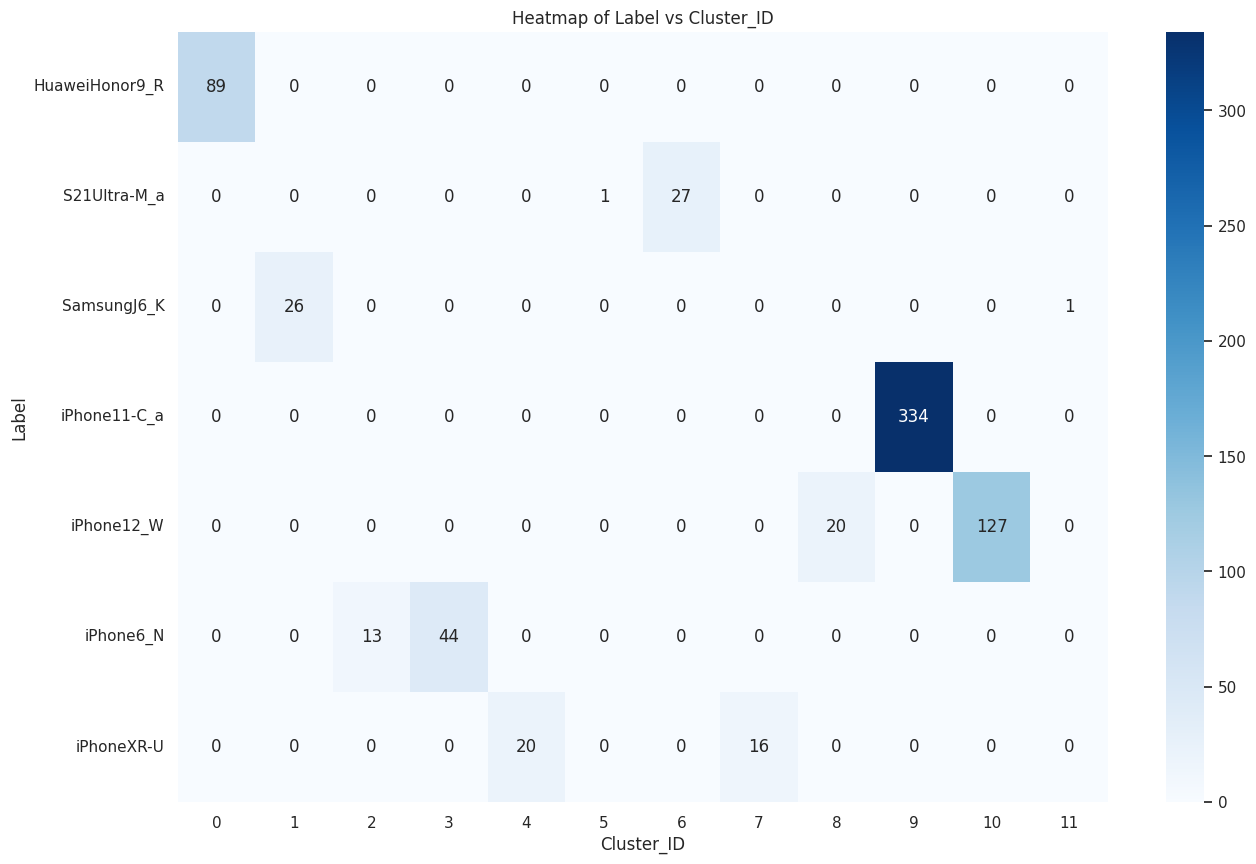


Perfomance on train_dataset using ['HT Capabilities', 'Length'] features in a cluster:


,train_dataset
Homogeneous,1.000000
completeness,0.900375
V_measure,0.947576
Error,5.000000


Although, v_measurement is admireable, the error is not so good since we have 7 device but 12 clusters
It means we must change our clustering


In [31]:
train_performance_table = performance_on_train_dataset(random_selected_features)
plot_heatmap(train_cluster_df,'Label','Cluster_ID')

print(f'\nPerfomance on train_dataset using {random_selected_features} features in a cluster:')
print('='*80)

display(train_performance_table)
no_labels = len(np.unique(train_cluster_df["Label"]))
no_clusters = len(np.unique(train_cluster_df['Cluster_ID']))
print('='*80)
print(f'Although, v_measurement is admireable, the error is not so good since we have {no_labels} device but {no_clusters} clusters')
print('It means we must change our clustering')

# 7)Validation part

## 7_1)Prepare val_dataset using different K

In [32]:
def load_val_datasets(no_dataset_to_load):

  base_dir = '/content/challenge-dataset'

  df_list = list()


  for root, dirs, files in os.walk(base_dir):
    files = random.sample(files,no_dataset_to_load )
    #print(files)
    for file in enumerate(files):
      if file[1].endswith(".csv"):
        file_path = os.path.join(root,file[1])
        df = pd.read_csv(file_path)
        df_list.append(df)
        #value +=1


  raw_val_dataset = pd.concat(df_list, ignore_index=True)

  raw_val_dataset['Timestamp']=pd.to_datetime(raw_val_dataset['Timestamp'], unit='s')

  # display(raw_val_dataset)
  return raw_val_dataset



In [33]:
def create_5_val_dataset(k):

  os.makedirs(f"/content/validation_dataset/K={k}")
  if k !=6:
    for i in range(1,6):
      val_dataset = load_val_datasets(k)
      val_dataset.to_csv(f"/content/validation_dataset/K={k}/val_dataset_{i}.csv", index=False)


  else:
    val_dataset = load_val_datasets(k)
    val_dataset.to_csv(f"/content/validation_dataset/K={k}/val_dataset_1.csv", index=False)



In [34]:
!rm -rf '/content/validation_dataset'

In [35]:
# We need to iterate K=2 to K=6, so that for k=2 we have 5 test_dataset of 2 random devices, for
# k= 3 we have 5 test_datasets of 3 random devices and ... .But for k=6, we have 1 test_dataset of 6 devices.
# We have 6 devices in total
for k in range(2,7):
  create_5_val_dataset(k)

print('all datasets have been created in validation_dataset folder deonted with different K')

all datasets have been created in validation_dataset folder deonted with different K


## 7_2)Performance on val_datasets

In [36]:
def performance_on_val_dataset(selected_features):

  val_performance_table = pd.DataFrame({},index=['Homogeneous','completeness','V_measure','Error'])

  for k in range(2,7):
    base_dir = f'/content/validation_dataset/K={k}'
    df_list = list()

    for root, dirs, files in os.walk(base_dir):
      files = sorted(files)
      for file in enumerate(files):
        if file[1].endswith(".csv") and file[1].startswith('val'):
          file_path = os.path.join(root,file[1])
          val_df = pd.read_csv(file_path)

        # drop unneccessary columns like training part
          val_df.drop(['SSID', 'VHT Capabilities', 'HE Capabilities'],axis=1,inplace=True)

          # label encoding columns like training part
          encoded_val_df = encoder(val_df,features)

          # Add Cluster_ID based on selected features in training part
          encoded_val_df['Cluster_ID'] =  encoded_val_df.groupby(selected_features).ngroup()
          #display(encoded_val_df)

          # Recieve results
          result = homogeneity_completeness_v_measure(encoded_val_df["Label"],encoded_val_df[f"Cluster_ID"])
          # add Error performance to result
          n_unique_clusterid = len(np.unique(encoded_val_df["Cluster_ID"]))
          n_unique_label = len(np.unique(encoded_val_df["Label"]))
          Error = n_unique_clusterid-n_unique_label

          result = list(result)
          result.append(Error)
          result = np.reshape(result,(4,1))
          number = int(file[1].split('_')[-1].split('.')[0])

          # Save result in a table
          val_performance_table[f'K{k}_val_dataset{number}'] = result




  # Create average performance
  val_ave_performance_table = pd.DataFrame({},index=['Ave_Homogeneous','Ave_completeness','Ave_V_measure','Ave_Error'])

  start_k = 2
  for i in range(5,21,5):
    val_ave_performance_table[f'K={start_k}'] = 0
    Ave_Homogeneous = val_performance_table.loc['Homogeneous'][i-5:i].mean()
    val_ave_performance_table[f'K={start_k}'].iloc[0] = Ave_Homogeneous

    Ave_completeness = val_performance_table.loc['completeness'][i-5:i].mean()
    val_ave_performance_table[f'K={start_k}'].iloc[1] = Ave_completeness

    Ave_V_measure = val_performance_table.loc['V_measure'][i-5:i].mean()
    val_ave_performance_table[f'K={start_k}'].iloc[2] =  Ave_V_measure

    Ave_Error = val_performance_table.loc['Error'][i-5:i].mean()
    val_ave_performance_table[f'K={start_k}'].iloc[3] = Ave_Error
    start_k +=1

  # Add k= 6 to the ave_performance_table

  val_ave_performance_table[f'K=6'] = val_performance_table['K6_val_dataset1'].values

  all = [val_ave_performance_table[:].iloc[0].mean()]
  all.append(val_ave_performance_table[:].iloc[1].mean())
  all.append(val_ave_performance_table[:].iloc[2].mean())
  all.append(val_ave_performance_table[:].iloc[3].mean())
  val_ave_performance_table['Ave_all'] = all





  return val_performance_table, val_ave_performance_table

In [37]:
def plot_graphs():
  df = val_ave_performance_table.iloc[:-1, :-1]
  # Plotting
  fig = plt.figure(figsize=(10, 8))

  # Plot each row as a separate line with different colors and markers
  colors = ['blue', 'green', 'red', 'purple']
  markers = ['o', 's', '^', 'D']

  k = [2,3,4,5,6]
  for i, (index, row) in enumerate(df.iterrows()):  # enumerate with index and row directly
      plt.plot(k, row, label=index, color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-')

  plt.xlabel('K')
  plt.ylabel('Values')
  plt.title(f'Average Performance for different k using {random_selected_features} as a Cluster')
  plt.xticks(k)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()  # Automatically adjusts subplots to fit into the figure area
  plt.show()

  figsize=(20, 32)
  Error = val_ave_performance_table.iloc[-1,:-1]
  # Plot each row as a separate line with different colors and markers


  k = [2,3,4,5,6]

  plt.plot(k, Error, label='Error', color='Red', marker='o', linestyle='-')
  plt.xlabel('K')
  plt.ylabel('Values')
  plt.title(f'Average Performance for different k using {random_selected_features} as a Cluster')
  plt.xticks(k)
  plt.legend()
  plt.grid(True)
  plt.tight_layout()  # Automatically adjusts subplots to fit into the figure area

  plt.show()


Perfomance on val_dataset using ['HT Capabilities', 'Length'] in a cluster:


,K2_val_dataset1,K2_val_dataset2,K2_val_dataset3,K2_val_dataset4,K2_val_dataset5,K3_val_dataset1,K3_val_dataset2,K3_val_dataset3,K3_val_dataset4,K3_val_dataset5,...,K4_val_dataset2,K4_val_dataset3,K4_val_dataset4,K4_val_dataset5,K5_val_dataset1,K5_val_dataset2,K5_val_dataset3,K5_val_dataset4,K5_val_dataset5,K6_val_dataset1
Homogeneous,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
completeness,0.572428,0.663285,0.540800,0.579052,0.376120,0.646136,0.653800,0.662630,0.648843,0.636637,...,0.705603,0.705603,0.703819,0.715058,0.757387,0.735479,0.731398,0.750264,0.757387,0.764927
V_measure,0.728082,0.797560,0.701973,0.733417,0.546639,0.785034,0.790664,0.797087,0.787029,0.777982,...,0.827394,0.827394,0.826167,0.833859,0.861947,0.847581,0.844864,0.857315,0.861947,0.866809
Error,2.000000,2.000000,4.000000,3.000000,3.000000,4.000000,5.000000,3.000000,4.000000,5.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000,7.000000,7.000000,6.000000,8.000000


,K=2,K=3,K=4,K=5,K=6,Ave_all
Ave_Homogeneous,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Ave_completeness,0.546337,0.649609,0.710374,0.746383,0.764927,0.683526
Ave_V_measure,0.701534,0.787559,0.830646,0.854731,0.866809,0.808256
Ave_Error,2.800000,4.200000,5.800000,6.600000,8.000000,5.480000


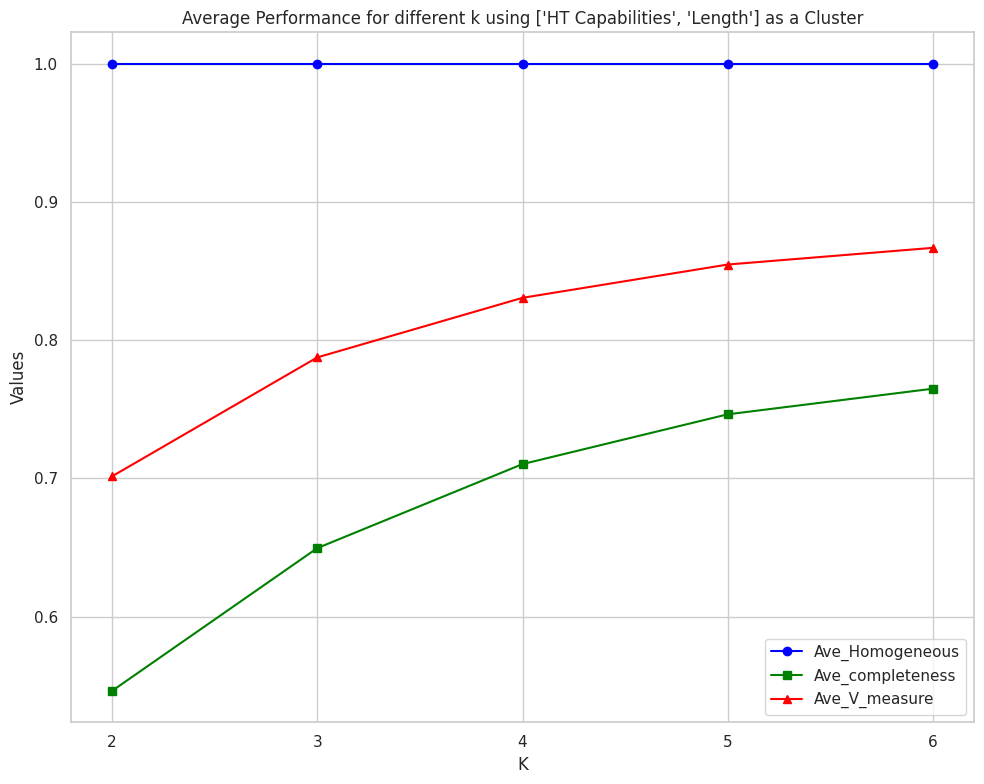

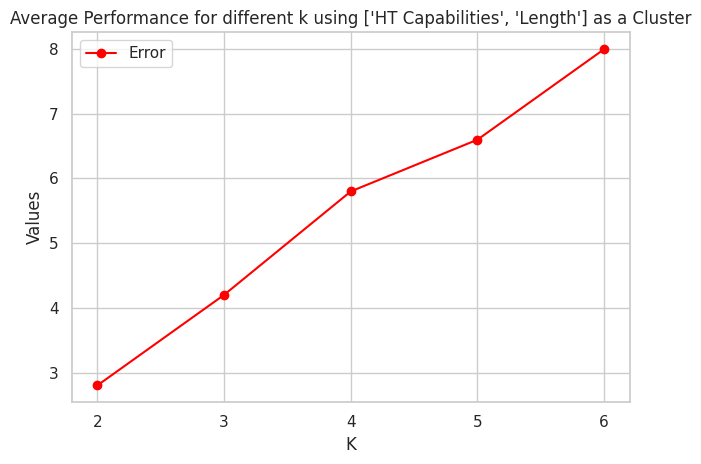

As you see, althoug average perofmance is acceptable, Error value is high, so we need to use better features in diffrent clusters


In [38]:
val_performance_table, val_ave_performance_table = performance_on_val_dataset(random_selected_features)
print(f'Perfomance on val_dataset using {random_selected_features} in a cluster:')
print('='*80)
display(val_performance_table)
print('='*100)
display(val_ave_performance_table)
plot_graphs()

print('As you see, althoug average perofmance is acceptable, Error value is high, so we need to use better features in diffrent clusters')

# 8) Choose best clusters using the most important features

In [39]:
train_total_table = pd.DataFrame({})
val_total_table = pd.DataFrame({})

for featrue_item in recommended_Clusters_list:

  train_performance_table= performance_on_train_dataset(featrue_item)

  train_total_table = pd.concat([train_total_table, train_performance_table], axis=1)

  val_performance_table, val_ave_performance_table = performance_on_val_dataset(featrue_item)
  val_total_table = pd.concat([val_total_table, val_ave_performance_table['Ave_all']], axis=1)


column_names = best_clusters.columns.copy()
column_names = list(column_names)
#column_names.remove('Cluster_2')
#column_names.remove('Cluster_3')
train_total_table.columns = column_names
val_total_table.columns = column_names



In [40]:
print('Result on training dataset using different clusters:')
print('='*80)
display(train_total_table)

print('\n\n\nResult on validation dataset using different clusters:')
print('='*80)
display(val_total_table)

Result on training dataset using different clusters:


,Cluster_2,Cluster_3,Cluster_12,Cluster_23,Cluster_24,Cluster_26,Cluster_28,Cluster_30,Cluster_54,Cluster_79,Cluster_83,Cluster_88
Homogeneous,0.732336,0.664772,0.484023,0.732336,0.732336,0.664772,0.664772,0.725847,0.484023,0.732336,0.664772,0.725847
completeness,0.965429,0.956649,0.466338,0.965429,0.965429,0.956649,0.956649,0.989413,0.466338,0.965429,0.956649,0.989413
V_measure,0.832881,0.784440,0.475016,0.832881,0.832881,0.784440,0.784440,0.837381,0.475016,0.832881,0.784440,0.837381
Error,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000





Result on validation dataset using different clusters:


,Cluster_2,Cluster_3,Cluster_12,Cluster_23,Cluster_24,Cluster_26,Cluster_28,Cluster_30,Cluster_54,Cluster_79,Cluster_83,Cluster_88
Ave_Homogeneous,1.0,0.919624,0.625971,1.0,1.0,1.000000,0.919624,0.963095,0.625971,1.0,1.000000,0.963095
Ave_completeness,1.0,0.977581,0.415555,1.0,1.0,0.929827,0.977581,0.946108,0.415555,1.0,0.929827,0.946108
Ave_V_measure,1.0,0.944243,0.490714,1.0,1.0,0.961613,0.944243,0.952053,0.490714,1.0,0.961613,0.952053
Ave_Error,0.0,0.400000,2.800000,0.0,0.0,2.680000,0.400000,1.360000,2.800000,0.0,2.680000,1.360000


###8_1)Bestrecommended clusters

In [41]:
# Choose 8 best clusters from above table
best_clusters = {'Cluster_2': [list(all_feature_combinations[2])],
                 'Cluster_3': [list(all_feature_combinations[3])],
                 'Cluster_23':[list(all_feature_combinations[23])],
                 'Cluster_24':[list(all_feature_combinations[24])],
                 'Cluster_28':[list(all_feature_combinations[28])],
                 'Cluster_30':[list(all_feature_combinations[30])],
                 'Cluster_79':[list(all_feature_combinations[79])],
                 'Cluster_88':[list(all_feature_combinations[88])]}


print('Best recommended clusters: ')
print('='*80)
for key in best_clusters.keys():
  print(key,end='\t')
  print(best_clusters[key])


Best recommended clusters: 
Cluster_2	[['HT Capabilities']]
Cluster_3	[['Extended Capabilities']]
Cluster_23	[['HT Capabilities', 'Supported Rates']]
Cluster_24	[['HT Capabilities', 'Extended Supported Rates']]
Cluster_28	[['Extended Capabilities', 'Extended Supported Rates']]
Cluster_30	[['Vendor Specific Tags', 'Supported Rates']]
Cluster_79	[['HT Capabilities', 'Supported Rates', 'Extended Supported Rates']]
Cluster_88	[['Vendor Specific Tags', 'Supported Rates', 'Extended Supported Rates']]


# 9)Test part

## 9_1)Load test dataset

In [42]:
test_dataset = pd.read_csv('/content/MAC_derand_unlabelled-challenge.csv')

# Group
# see unique mac addresses
unique_mac_addresses = len(np.unique(test_dataset['MAC Address']))
print(f'We have: {unique_mac_addresses} unique Mac addresses')
grouped_test_dataset = test_dataset.groupby(['MAC Address']) # Group by Mac Address
grouped_test_dataset = grouped_test_dataset.first().reset_index() # Show first row of groupd mac address


random_selected_features =   ['HT Capabilities', 'Supported Rates', 'Extended Supported Rates']
test_cluster_df = grouped_test_dataset.copy()
test_cluster_df['Cluster_ID'] =  test_cluster_df.groupby(random_selected_features).ngroup()
print('Here, Cluster_88 has been added to df')
print('='*100)
display(test_cluster_df)

We have: 1501 unique Mac addresses
Here, Cluster_88 has been added to df


,MAC Address,Timestamp,Channel,DS Channel,HT Capabilities,Extended Capabilities,Vendor Specific Tags,SSID,Supported Rates,Extended Supported Rates,VHT Capabilities,HE Capabilities,Length,Cluster_ID
0,02:02:70:30:b6:43,1.625073e+09,1,3.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,143,3
1,02:0b:5b:9e:41:54,1.623904e+09,1,2.0,631117ffff000000000000000000000000000000000000...,0000088001400040,00904c0408bf0c3230900ffaff0000faff0000,None,02040b16,0c1218243048606c,None,None,154,4
2,02:0b:72:cb:7d:eb,1.623851e+09,11,9.0,631117ffff000000000000000000000000000000000000...,0000088001400040,00904c0408bf0c3230900ffaff0000faff0000,None,02040b16,0c1218243048606c,None,None,154,4
3,02:0c:01:7e:50:d6,1.623850e+09,11,13.0,631117ffff000000000000000000000000000000000000...,0000088001400040,00904c0408bf0c3230900ffaff0000faff0000,None,02040b16,0c1218243048606c,None,None,154,4
4,02:11:33:61:b5:ef,1.625073e+09,1,2.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,143,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,fe:c5:50:16:eb:8c,1.625074e+09,11,11.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,131,3
1497,fe:ed:a5:45:e8:b9,1.626773e+09,11,11.0,ad0113ffff000000000000000000000000000000000000...,04000a82004000408001,0050f208002700,None,02040b16,0c1218243048606c,92f99133faff6203faff6203,02001f,143,5
1498,fe:f5:97:dd:58:86,1.625076e+09,6,8.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,143,3
1499,fe:f9:ac:47:0d:b7,1.625073e+09,11,11.0,2d401bff00000000000000000000000000000000000000...,0000080400000040,None,None,82848b96,0c1218243048606c,None,23010808180080203002000d009f08000000fdfffdff39...,131,3


## 9_2)Predict number of devices
The model tries to look at the probs available on test dataset one by one. If probe request features mathes the cluster features
, it takes an old cluster, otherwise it takes new cluster


In [43]:
No_of_diveces = {}
for cluster in best_clusters.keys():
  features = best_clusters[cluster][0]
  test_cluster_df = grouped_test_dataset.copy()
  test_cluster_df[cluster] =  test_cluster_df.groupby(features).ngroup()
  No_of_diveces[cluster] =len(np.unique(test_cluster_df[cluster]))

for prediction in No_of_diveces.keys():
  print(prediction,f'predicts {No_of_diveces[prediction]} devices on test dataset')

print('='*80)
print('Based on Max voting of the above results, the number of devices is: 8 ')


Cluster_2 predicts 7 devices on test dataset
Cluster_3 predicts 8 devices on test dataset
Cluster_23 predicts 8 devices on test dataset
Cluster_24 predicts 7 devices on test dataset
Cluster_28 predicts 8 devices on test dataset
Cluster_30 predicts 6 devices on test dataset
Cluster_79 predicts 8 devices on test dataset
Cluster_88 predicts 6 devices on test dataset
Based on Max voting of the above results, the number of devices is: 8 


#10_ Conclusion

After looking at **1_correlation matrix**, **2_mutual information**, **3_heatmaps** and **4_broute force** methods. we understood the importance of each feature so that the following features are recommended to use in clustering.


```
'HT Capabilities', 'Extended Capabilities', 'Supported Rates', 'Extended Supported Rates'
```
For understanding which combination of features could be better in clustering we used **Broute Force Algorithm** since our problem is not completed and brote force works well as it considers all possibles states. The following combinations are the results:


```
Cluster_2:	 [['HT Capabilities']]
Cluster_3:     [['Extended Capabilities']]
Cluster_23:	[['HT Capabilities', 'Supported Rates']]
Cluster_24:	[['HT Capabilities', 'Extended Supported Rates']]
Cluster_28:	[['Extended Capabilities', 'Extended Supported Rates']]
Cluster_30:	[['Vendor Specific Tags', 'Supported Rates']]
Cluster_79:	[['HT Capabilities', 'Supported Rates', 'Extended Supported Rates']]
Cluster_88:	[['Vendor Specific Tags', 'Supported Rates', 'Extended Supported Rates']]
```


For making prediction and bing more sure about our results, we used **Max voting**  using above clusters and these are the resutls:



```
Cluster_2 predicts   7 devices on test dataset
Cluster_3 predicts   8 devices on test dataset
Cluster_23 predicts  8 devices on test dataset
Cluster_24 predicts  7 devices on test dataset
Cluster_28 predicts  8 devices on test dataset
Cluster_30 predicts  6 devices on test dataset
Cluster_79 predicts  8 devices on test dataset
Cluster_88 predicts  6 devices on test dataset
```

So final prediction for the number of devices, based on max voting, is:  **8**

Also, between these clusters, we have chosen **cluster 79** to report it as one of the best combinations with the following result on training and validation datasets:

```
Training part                 Validation part
=====================================================
Homogeneous     0.732336      Ave_Homogeneous     1.0
completeness    0.965429      Ave_completeness    1.0
V_measure       0.832881      Ave_V_measure       1.0
Error           1.000000      Ave_Error           0.0                            
```



